In [63]:
%matplotlib notebook
from utils.converter import *
import math
from scipy.fft import fft, ifft, fftfreq
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('support-files/qubit.mplstyle')

FLUX = float
FLUX_NUMBER = int
cos = np.cos
sin = np.sin
pi = np.pi

fF = 10 ** (-15)
c = 10**(-10) #F/m Capacitance on interface
h = 6.64 * 10**(-34)
e = 1.6 * 10**(-19)
um = 10**(-6)
GHz = 10**(9)
ns = 10**(-9)
kOhm = 10**3
Rq = 6.484*kOhm
Delta = 3.1*10**(-23) # Superconducting delta
kb = 1.38 * 10**(-23)
Phi0 = h/(2 * e)
Gauss = 10**(-4) # Gauss to Wb/m²
kHz = 10**3
twoPi = 2*np.pi
MHz = 10**6

MY_COLOURS = {
    "DarkBlue": "#104e8b",     # dark blue (DodgerBlue4)
    "DarkRed": "#ed2200",     # dark red (red2)
    "Green": "#9acd32",     
    "Orange": "#ffc125",      # orange,
    "LightBlue": "#68838b",  # light steel blue,
    "Purple": "#6959cd",  # dark purple
    "Pink": "#ffa07a"  # pink salmon
}

# Pipepline runthrough
- Take the signal on the SPA at each stage in order to see the signal and noise
- `-2dBm`
- `4.48GHz`
- `10ns`

$P^{max}_{coherent} = \frac{\hbar\omega_0}{8}\Gamma_1$ - all this power will be localised at the very strong middle peak

$P^{max}_{incoherent} = \frac{\hbar\omega_0}{2}\Gamma_1$ - all this power will be spread over a wide range of the order of $\Gamma_1$

And we can approximate $\Gamma_1/2\pi = 1/T_1 \rightarrow \Gamma_1 = 5MHz$

In [19]:
# Power from the photon source
w0 = 4.48 * GHz
T1 = 30 * ns
Gamma_1 = 1/T1 * 2 * pi
INCOHRENT_SPREAD = 2 * Gamma_1 # Frequency range that the incoherent signal is spread over

signal_coherent_1 = hbar * w0 / 8 * Gamma_1 
signal_coherent_1_dBm = W_to_dBm(signal_coherent_1)

signal_incoherent_1 = hbar * w0 / 2 * Gamma_1
signal_incoherent_1_dBm = W_to_dBm(signal_incoherent_1)

signal_coherent_1_dBm, signal_incoherent_1_dBm

(-139.06765148345445, -133.04705157017483)

In [20]:
# Quinstar ciculator @ 13mK
T = 13 / 1000
gain = 0

noise = 4 * kb * T
noise_dBm = W_to_dBm(noise)

signal_coherent_2_dBm = signal_coherent_1_dBm + gain
signal_incoherent_2_dBm = signal_incoherent_1_dBm + gain
noise_2_dBm = noise_dBm

signal_coherent_2_dBm, signal_incoherent_2_dBm, noise_2_dBm

(-139.06765148345445, -133.04705157017483, -211.44117569963964)

In [127]:
# Cryogenic amplifier @ 5K noise from datasheet
T = 1
gain = 40
CORRECTION = 0
noise_temp = 4 * kb * T

signal_coherent_3_dBm = signal_coherent_2_dBm + gain
signal_incoherent_3_dBm = signal_incoherent_2_dBm + gain

noise_3_dBm = W_to_dBm(
    (dBm_to_W(noise_2_dBm) + noise_temp) * 10**(gain/10)
)

signal_coherent_3_dBm, signal_incoherent_3_dBm, noise_3_dBm

(-99.06765148345445, -93.04705157017483, -152.5245147691052)

## Signal at A
- Right out of system

<IPython.core.display.Javascript object>


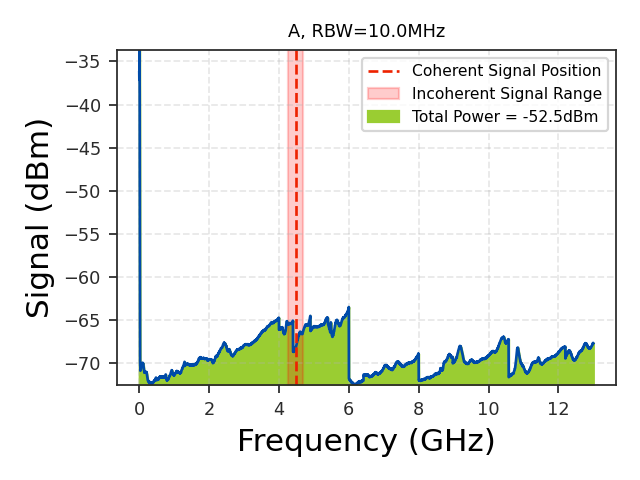

In [128]:
RBW = 10*MHz
FILENAME = "data/2021-08_photon-source/Ty_15_tracking-signal/Ty_15_tracking-signal_stage-A_wide.txt"

with open(FILENAME) as fin:
    data = np.loadtxt(fin, skiprows=1)
    data_x = data[:, 0] / 1000 # convert to GHz
    data_y = data[:, 1]
interpolation_dBm = InterpolatedUnivariateSpline(data_x, data_y, k=1)
interpolation_W = InterpolatedUnivariateSpline(data_x, dBm_to_W(data_y), k=1)
total_power = W_to_dBm(interpolation_W.integral(min(data_x), max(data_x)))
    
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(data_x, data_y)
ax.axvline(w0/GHz, color=MY_COLOURS["DarkRed"], label=f"Coherent Signal Position",
           linestyle="--")
ax.axvspan((w0 - INCOHRENT_SPREAD/2)/GHz, 
           (w0 + INCOHRENT_SPREAD/2)/GHz, 
           color="red", alpha=0.2, label="Incoherent Signal Range")
ax.fill_between(data_x, min(data_y), interpolation_dBm(data_x), 
                color=MY_COLOURS["Green"],
               label=f"Total Power = {total_power:.1f}dBm")
ax.legend(fontsize=7)
ax.set_ylim([min(data_y), max(data_y)])
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal (dBm)");
ax.set_title(f"A, RBW={RBW/MHz}MHz", size=8)
plt.tight_layout()

plt.savefig(FILENAME.replace("txt", "pdf"))

<IPython.core.display.Javascript object>


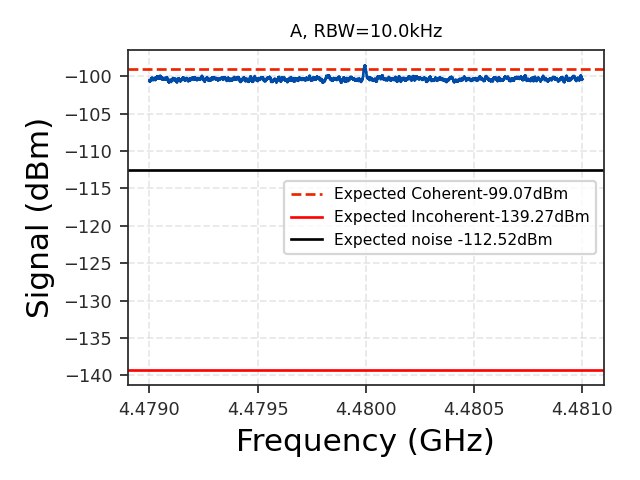

In [146]:
RBW = 10*kHz
FILENAME = "data/2021-08_photon-source/Ty_15_tracking-signal/Ty_15_tracking-signal_stage-A.txt"

noise = W_to_dBm(dBm_to_W(noise_3_dBm) * RBW) 
signal_coherent = signal_coherent_3_dBm
signal_incoherent = W_to_dBm(dBm_to_W(signal_incoherent_3_dBm) / INCOHRENT_SPREAD * RBW)

with open(FILENAME) as fin:
    data = np.loadtxt(fin, skiprows=1)
    
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.axhline(signal_coherent, color=MY_COLOURS["DarkRed"], 
           linestyle="--",
           label=f"Expected Coherent{signal_coherent:.2f}dBm")
ax.axhline(signal_incoherent, color="red", 
           label=f"Expected Incoherent{signal_incoherent:.2f}dBm")
ax.axhline(noise, color="black", label=f"Expected noise {noise:.2f}dBm")
ax.plot(data[:, 0]/1000, data[:, 1])
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal (dBm)")
ax.legend(fontsize=7)
ax.set_title(f"A, RBW={RBW/kHz}kHz", size=8)
plt.tight_layout()

plt.savefig(FILENAME.replace("txt", "pdf"))

In [147]:
# Amplifiers A0x
gain = 28
T = 295
noise_temp = 4*kb*T
noise_figure = 4

signal_coherent_4_dBm = signal_coherent_3_dBm + gain
signal_incoherent_4_dBm = signal_incoherent_3_dBm + gain
noise_4_dBm = W_to_dBm(
    dBm_to_W(noise_3_dBm + gain) + noise_temp * noise_figure
)

signal_coherent_4_dBm, signal_incoherent_4_dBm, noise_4_dBm

(-71.06765148345445, -65.04705157017483, -124.52371306005321)

## Signal at B (first amplifier)

In [148]:
LOCATION = "B"
_noise = noise_4_dBm
_signal_coherent = signal_coherent_4_dBm
_signal_incoherent = signal_incoherent_4_dBm

<IPython.core.display.Javascript object>


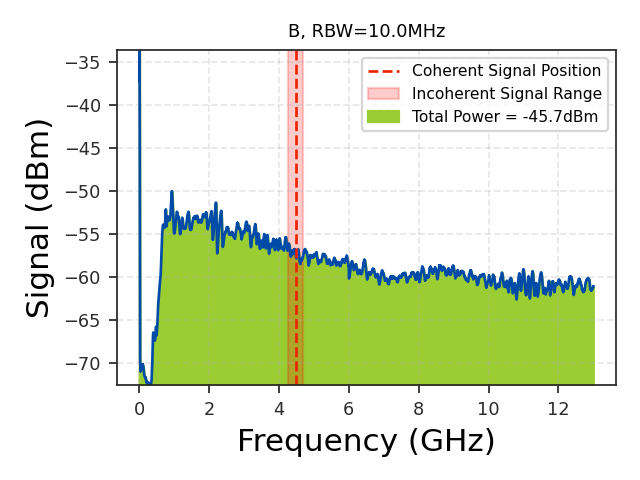

In [149]:
RBW = 10*MHz
FILENAME = "data/2021-08_photon-source/Ty_15_tracking-signal/Ty_15_tracking-signal_stage-B_wide.txt"

with open(FILENAME) as fin:
    data = np.loadtxt(fin, skiprows=1)
    data_x = data[:, 0] / 1000 # convert to GHz
    data_y = data[:, 1]
interpolation_dBm = InterpolatedUnivariateSpline(data_x, data_y, k=1)
interpolation_W = InterpolatedUnivariateSpline(data_x, dBm_to_W(data_y), k=1)
total_power = W_to_dBm(interpolation_W.integral(min(data_x), max(data_x)))
    
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(data_x, data_y)
ax.axvline(w0/GHz, color=MY_COLOURS["DarkRed"], label=f"Coherent Signal Position",
           linestyle="--")
ax.axvspan((w0 - INCOHRENT_SPREAD/2)/GHz, 
           (w0 + INCOHRENT_SPREAD/2)/GHz, 
           color="red", alpha=0.2, label="Incoherent Signal Range")
ax.fill_between(data_x, min(data_y), interpolation_dBm(data_x), 
                color=MY_COLOURS["Green"],
               label=f"Total Power = {total_power:.1f}dBm")
ax.legend(fontsize=7)
ax.set_ylim([min(data_y), max(data_y)])
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal (dBm)");
ax.set_title(f"{LOCATION}, RBW={RBW/MHz}MHz", size=8)
plt.tight_layout()

plt.savefig(FILENAME.replace("txt", "pdf"))

<IPython.core.display.Javascript object>


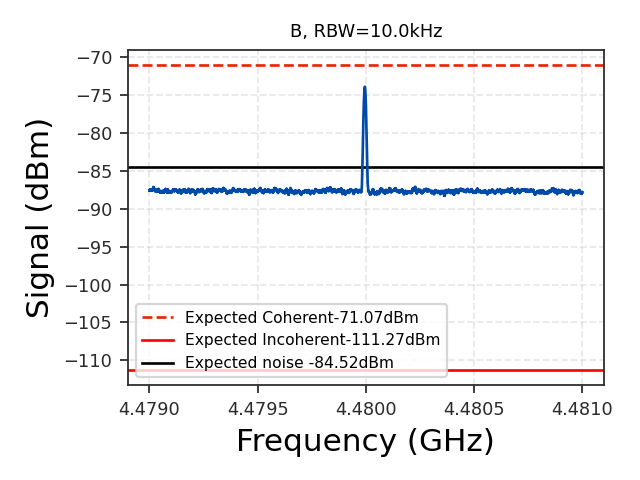

In [150]:
RBW = 10*kHz
FILENAME = "data/2021-08_photon-source/Ty_15_tracking-signal/Ty_15_tracking-signal_stage-B.txt"

noise = W_to_dBm(dBm_to_W(_noise) * RBW) 
signal_incoherent = W_to_dBm(dBm_to_W(_signal_incoherent) / INCOHRENT_SPREAD * RBW)

with open(FILENAME) as fin:
    data = np.loadtxt(fin, skiprows=1)
    
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.axhline(_signal_coherent, color=MY_COLOURS["DarkRed"], 
           linestyle="--",
           label=f"Expected Coherent{_signal_coherent:.2f}dBm")
ax.axhline(signal_incoherent, color="red", 
           label=f"Expected Incoherent{signal_incoherent:.2f}dBm")
ax.axhline(noise, color="black", label=f"Expected noise {noise:.2f}dBm")
ax.plot(data[:, 0]/1000, data[:, 1])
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal (dBm)")
ax.legend(fontsize=7)
ax.set_title(f"{LOCATION}, RBW={RBW/kHz}kHz", size=8)
plt.tight_layout()

plt.savefig(FILENAME.replace("txt", "pdf"))

In [151]:
# Amplifiers A0x
gain = 28
T = 295
noise_temp = 4*kb*T
noise_figure = 4

signal_coherent_5_dBm = signal_coherent_4_dBm + gain
signal_incoherent_5_dBm = signal_incoherent_4_dBm + gain
noise_5_dBm = W_to_dBm(
    dBm_to_W(noise_4_dBm + gain) + noise_temp * noise_figure
)

signal_coherent_5_dBm, signal_incoherent_5_dBm, noise_5_dBm

(-43.067651483454455, -37.04705157017483, -96.52371178954745)

## Signal at C (second amplifier)

In [152]:
LOCATION = "C"
_noise = noise_5_dBm
_signal_coherent = signal_coherent_5_dBm
_signal_incoherent = signal_incoherent_5_dBm

<IPython.core.display.Javascript object>


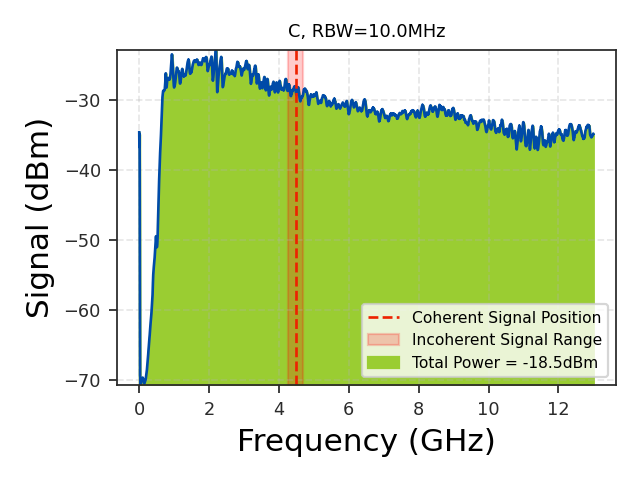

In [153]:
RBW = 10*MHz
FILENAME = "data/2021-08_photon-source/Ty_15_tracking-signal/Ty_15_tracking-signal_stage-C_wide.txt"

with open(FILENAME) as fin:
    data = np.loadtxt(fin, skiprows=1)
    data_x = data[:, 0] / 1000 # convert to GHz
    data_y = data[:, 1]
interpolation_dBm = InterpolatedUnivariateSpline(data_x, data_y, k=1)
interpolation_W = InterpolatedUnivariateSpline(data_x, dBm_to_W(data_y), k=1)
total_power = W_to_dBm(interpolation_W.integral(min(data_x), max(data_x)))
    
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(data_x, data_y)
ax.axvline(w0/GHz, color=MY_COLOURS["DarkRed"], label=f"Coherent Signal Position",
           linestyle="--")
ax.axvspan((w0 - INCOHRENT_SPREAD/2)/GHz, 
           (w0 + INCOHRENT_SPREAD/2)/GHz, 
           color="red", alpha=0.2, label="Incoherent Signal Range")
ax.fill_between(data_x, min(data_y), interpolation_dBm(data_x), 
                color=MY_COLOURS["Green"],
               label=f"Total Power = {total_power:.1f}dBm")
ax.legend(fontsize=7)
ax.set_ylim([min(data_y), max(data_y)])
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal (dBm)");
ax.set_title(f"{LOCATION}, RBW={RBW/MHz}MHz", size=8)
plt.tight_layout()

plt.savefig(FILENAME.replace("txt", "pdf"))

<IPython.core.display.Javascript object>


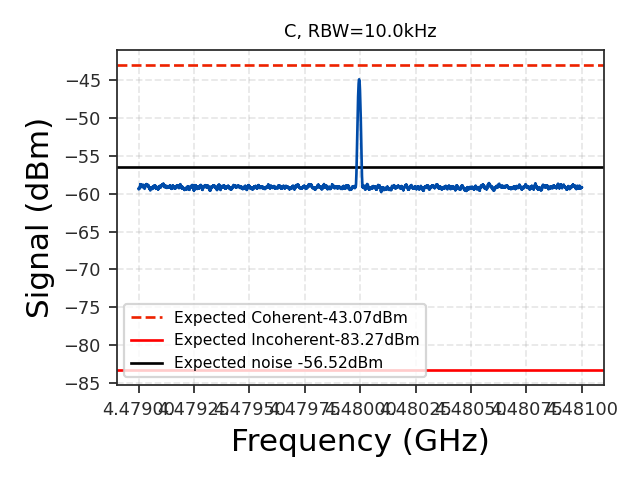

In [154]:
RBW = 10*kHz
FILENAME = "data/2021-08_photon-source/Ty_15_tracking-signal/Ty_15_tracking-signal_stage-C.txt"

noise = W_to_dBm(dBm_to_W(_noise) * RBW) 
signal_incoherent = W_to_dBm(dBm_to_W(_signal_incoherent) / INCOHRENT_SPREAD * RBW)

with open(FILENAME) as fin:
    data = np.loadtxt(fin, skiprows=1)
    
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.axhline(_signal_coherent, color=MY_COLOURS["DarkRed"], 
           linestyle="--",
           label=f"Expected Coherent{_signal_coherent:.2f}dBm")
ax.axhline(signal_incoherent, color="red", 
           label=f"Expected Incoherent{signal_incoherent:.2f}dBm")
ax.axhline(noise, color="black", label=f"Expected noise {noise:.2f}dBm")
ax.plot(data[:, 0]/1000, data[:, 1])
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal (dBm)")
ax.legend(fontsize=7)
ax.set_title(f"{LOCATION}, RBW={RBW/kHz}kHz", size=8)
plt.tight_layout()

plt.savefig(FILENAME.replace("txt", "pdf"))

## Signal at D (Filter)

In [155]:
LOCATION = "D"
_noise = noise_5_dBm
_signal_coherent = signal_coherent_5_dBm
_signal_incoherent = signal_incoherent_5_dBm

<IPython.core.display.Javascript object>


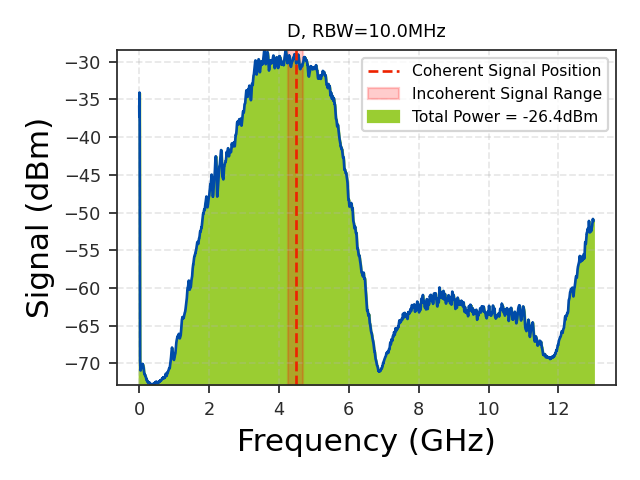

In [156]:
RBW = 10*MHz
FILENAME = "data/2021-08_photon-source/Ty_15_tracking-signal/Ty_15_tracking-signal_stage-D_wide.txt"

with open(FILENAME) as fin:
    data = np.loadtxt(fin, skiprows=1)
    data_x = data[:, 0] / 1000 # convert to GHz
    data_y = data[:, 1]
interpolation_dBm = InterpolatedUnivariateSpline(data_x, data_y, k=1)
interpolation_W = InterpolatedUnivariateSpline(data_x, dBm_to_W(data_y), k=1)
total_power = W_to_dBm(interpolation_W.integral(min(data_x), max(data_x)))
    
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(data_x, data_y)
ax.axvline(w0/GHz, color=MY_COLOURS["DarkRed"], label=f"Coherent Signal Position",
           linestyle="--")
ax.axvspan((w0 - INCOHRENT_SPREAD/2)/GHz, 
           (w0 + INCOHRENT_SPREAD/2)/GHz, 
           color="red", alpha=0.2, label="Incoherent Signal Range")
ax.fill_between(data_x, min(data_y), interpolation_dBm(data_x), 
                color=MY_COLOURS["Green"],
               label=f"Total Power = {total_power:.1f}dBm")
ax.legend(fontsize=7)
ax.set_ylim([min(data_y), max(data_y)])
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal (dBm)");
ax.set_title(f"{LOCATION}, RBW={RBW/MHz}MHz", size=8)
plt.tight_layout()

plt.savefig(FILENAME.replace("txt", "pdf"))

<IPython.core.display.Javascript object>


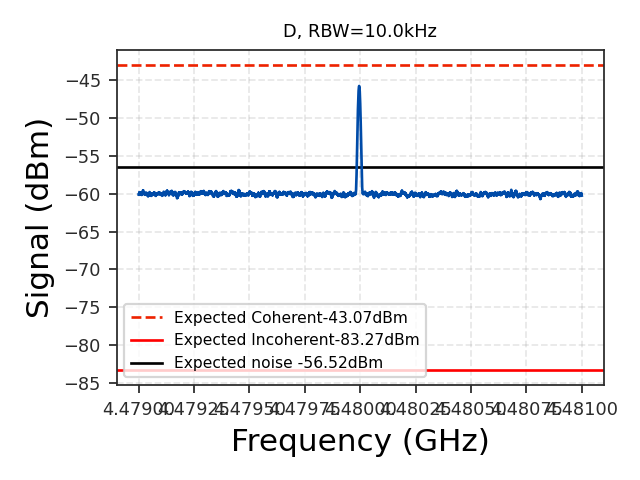

In [157]:
RBW = 10*kHz
FILENAME = "data/2021-08_photon-source/Ty_15_tracking-signal/Ty_15_tracking-signal_stage-D.txt"

noise = W_to_dBm(dBm_to_W(_noise) * RBW) 
signal_incoherent = W_to_dBm(dBm_to_W(_signal_incoherent) / INCOHRENT_SPREAD * RBW)

with open(FILENAME) as fin:
    data = np.loadtxt(fin, skiprows=1)
    
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.axhline(_signal_coherent, color=MY_COLOURS["DarkRed"], 
           linestyle="--",
           label=f"Expected Coherent{_signal_coherent:.2f}dBm")
ax.axhline(signal_incoherent, color="red", 
           label=f"Expected Incoherent{signal_incoherent:.2f}dBm")
ax.axhline(noise, color="black", label=f"Expected noise {noise:.2f}dBm")
ax.plot(data[:, 0]/1000, data[:, 1])
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal (dBm)")
ax.legend(fontsize=7)
ax.set_title(f"{LOCATION}, RBW={RBW/kHz}kHz", size=8)
plt.tight_layout()

plt.savefig(FILENAME.replace("txt", "pdf"))

In [183]:
# Amplifiers A0x
gain = 25- 6 # attenuation to not oversaturate the final amplifier
T = 295
noise_temp = 4*kb*T
noise_figure = 4

signal_coherent_6_dBm = signal_coherent_5_dBm + gain
signal_incoherent_6_dBm = signal_incoherent_5_dBm + gain
noise_6_dBm = W_to_dBm(
    dBm_to_W(noise_5_dBm + gain) + noise_temp * noise_figure
)

signal_coherent_6_dBm, signal_incoherent_6_dBm, noise_6_dBm

(-24.067651483454455, -18.04705157017483, -77.52371177355273)

## Signal at E (third amplifier)

In [184]:
LOCATION = "E (After third amplifier)"
_noise = noise_6_dBm
_signal_coherent = signal_coherent_6_dBm
_signal_incoherent = signal_incoherent_6_dBm

<IPython.core.display.Javascript object>


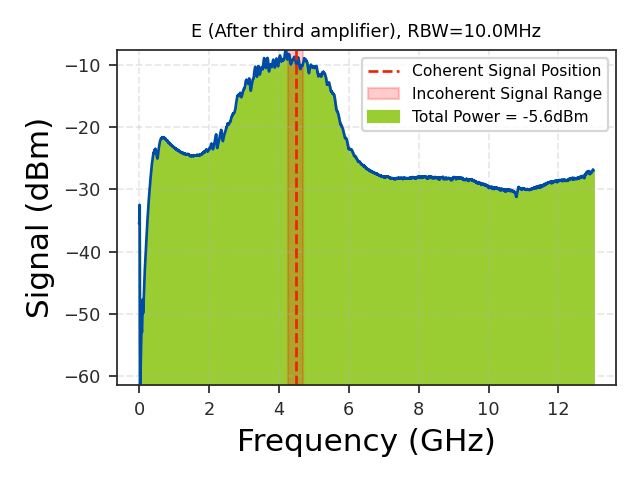

In [185]:
RBW = 10*MHz
FILENAME = "data/2021-08_photon-source/Ty_15_tracking-signal/Ty_15_tracking-signal_stage-E_wide.txt"

with open(FILENAME) as fin:
    data = np.loadtxt(fin, skiprows=1)
    data_x = data[:, 0] / 1000 # convert to GHz
    data_y = data[:, 1]
interpolation_dBm = InterpolatedUnivariateSpline(data_x, data_y, k=1)
interpolation_W = InterpolatedUnivariateSpline(data_x, dBm_to_W(data_y), k=1)
total_power = W_to_dBm(interpolation_W.integral(min(data_x), max(data_x)))
    
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(data_x, data_y)
ax.axvline(w0/GHz, color=MY_COLOURS["DarkRed"], label=f"Coherent Signal Position",
           linestyle="--")
ax.axvspan((w0 - INCOHRENT_SPREAD/2)/GHz, 
           (w0 + INCOHRENT_SPREAD/2)/GHz, 
           color="red", alpha=0.2, label="Incoherent Signal Range")
ax.fill_between(data_x, min(data_y), interpolation_dBm(data_x), 
                color=MY_COLOURS["Green"],
               label=f"Total Power = {total_power:.1f}dBm")
ax.legend(fontsize=7)
ax.set_ylim([min(data_y), max(data_y)])
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal (dBm)");
ax.set_title(f"{LOCATION}, RBW={RBW/MHz}MHz", size=8)
plt.tight_layout()

plt.savefig(FILENAME.replace("txt", "pdf"))

<IPython.core.display.Javascript object>


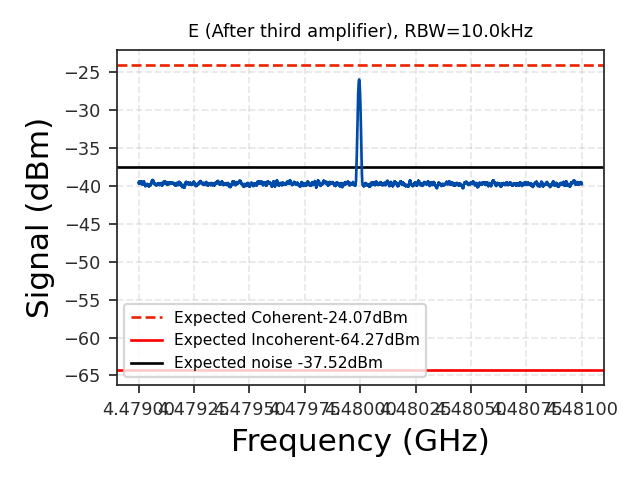

In [186]:
RBW = 10*kHz
FILENAME = "data/2021-08_photon-source/Ty_15_tracking-signal/Ty_15_tracking-signal_stage-E.txt"

noise = W_to_dBm(dBm_to_W(_noise) * RBW) 
signal_incoherent = W_to_dBm(dBm_to_W(_signal_incoherent) / INCOHRENT_SPREAD * RBW)

with open(FILENAME) as fin:
    data = np.loadtxt(fin, skiprows=1)
    
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.axhline(_signal_coherent, color=MY_COLOURS["DarkRed"], 
           linestyle="--",
           label=f"Expected Coherent{_signal_coherent:.2f}dBm")
ax.axhline(signal_incoherent, color="red", 
           label=f"Expected Incoherent{signal_incoherent:.2f}dBm")
ax.axhline(noise, color="black", label=f"Expected noise {noise:.2f}dBm")
ax.plot(data[:, 0]/1000, data[:, 1])
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal (dBm)")
ax.legend(fontsize=7)
ax.set_title(f"{LOCATION}, RBW={RBW/kHz}kHz", size=8)
plt.tight_layout()

plt.savefig(FILENAME.replace("txt", "pdf"))

## Signal at F

In [191]:
LOCATION = "F (after another filter)"
_noise = noise_6_dBm
_signal_coherent = signal_coherent_6_dBm
_signal_incoherent = signal_incoherent_6_dBm

<IPython.core.display.Javascript object>


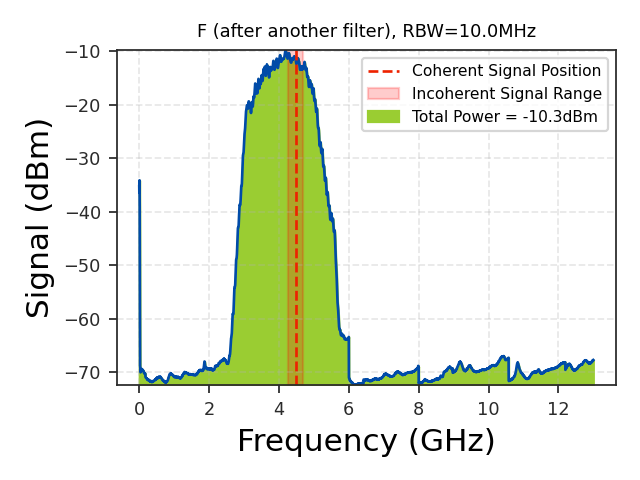

In [192]:
RBW = 10*MHz
FILENAME = "data/2021-08_photon-source/Ty_15_tracking-signal/Ty_15_tracking-signal_stage-F_wide.txt"

with open(FILENAME) as fin:
    data = np.loadtxt(fin, skiprows=1)
    data_x = data[:, 0] / 1000 # convert to GHz
    data_y = data[:, 1]
interpolation_dBm = InterpolatedUnivariateSpline(data_x, data_y, k=1)
interpolation_W = InterpolatedUnivariateSpline(data_x, dBm_to_W(data_y), k=1)
total_power = W_to_dBm(interpolation_W.integral(min(data_x), max(data_x)))
    
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(data_x, data_y)
ax.axvline(w0/GHz, color=MY_COLOURS["DarkRed"], label=f"Coherent Signal Position",
           linestyle="--")
ax.axvspan((w0 - INCOHRENT_SPREAD/2)/GHz, 
           (w0 + INCOHRENT_SPREAD/2)/GHz, 
           color="red", alpha=0.2, label="Incoherent Signal Range")
ax.fill_between(data_x, min(data_y), interpolation_dBm(data_x), 
                color=MY_COLOURS["Green"],
               label=f"Total Power = {total_power:.1f}dBm")
ax.legend(fontsize=7)
ax.set_ylim([min(data_y), max(data_y)])
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal (dBm)");
ax.set_title(f"{LOCATION}, RBW={RBW/MHz}MHz", size=8)
plt.tight_layout()

plt.savefig(FILENAME.replace("txt", "pdf"))

<IPython.core.display.Javascript object>


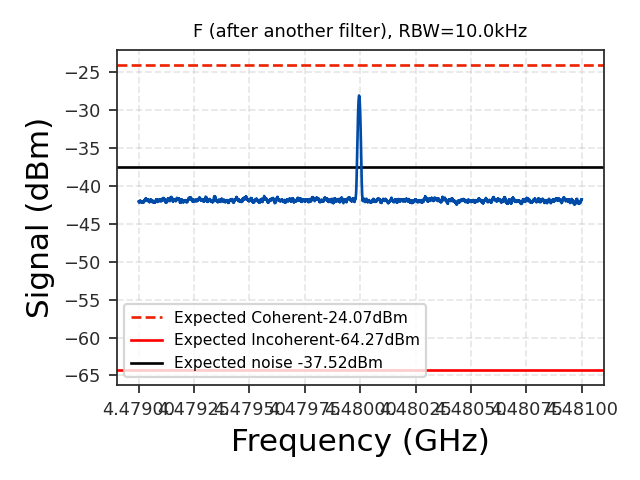

In [193]:
RBW = 10*kHz
FILENAME = "data/2021-08_photon-source/Ty_15_tracking-signal/Ty_15_tracking-signal_stage-F.txt"

noise = W_to_dBm(dBm_to_W(_noise) * RBW) 
signal_incoherent = W_to_dBm(dBm_to_W(_signal_incoherent) / INCOHRENT_SPREAD * RBW)

with open(FILENAME) as fin:
    data = np.loadtxt(fin, skiprows=1)
    
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.axhline(_signal_coherent, color=MY_COLOURS["DarkRed"], 
           linestyle="--",
           label=f"Expected Coherent{_signal_coherent:.2f}dBm")
ax.axhline(signal_incoherent, color="red", 
           label=f"Expected Incoherent{signal_incoherent:.2f}dBm")
ax.axhline(noise, color="black", label=f"Expected noise {noise:.2f}dBm")
ax.plot(data[:, 0]/1000, data[:, 1])
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal (dBm)")
ax.legend(fontsize=7)
ax.set_title(f"{LOCATION}, RBW={RBW/kHz}kHz", size=8)
plt.tight_layout()

plt.savefig(FILENAME.replace("txt", "pdf"))

In [202]:
# Amplifiers minicircuit
gain = 27 - 8 # because of previous filter and saturation
# Noise taken from calibration instead of temperature: jul-2021_-100dBm_spa_minicircuit
T = 295
noise_temp = 4*kb*T
noise_figure = 3

signal_coherent_7_dBm = signal_coherent_6_dBm + gain
signal_incoherent_7_dBm = signal_incoherent_6_dBm + gain
noise_7_dBm = W_to_dBm(
    dBm_to_W(noise_6_dBm + gain) + noise_temp * noise_figure
)

signal_coherent_7_dBm, signal_incoherent_7_dBm, noise_7_dBm

(-5.067651483454455, 0.9529484298251703, -58.523711773401715)

## Signal at G
At stage G, when incoherent measurements are made, we can see that incoherent signal is 30dB smaller than noise, and will require 1000 averages to recover

In [203]:
LOCATION = "G (after ZVA-183G-S+ amplifier)"
_noise = noise_7_dBm
_signal_coherent = signal_coherent_7_dBm
_signal_incoherent = signal_incoherent_7_dBm

<IPython.core.display.Javascript object>


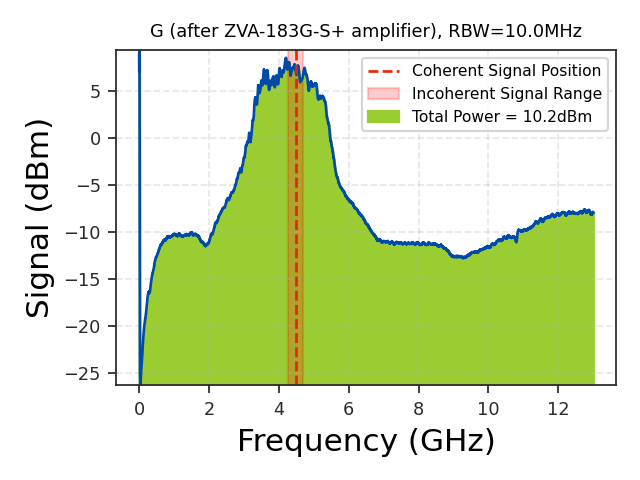

In [204]:
RBW = 10*MHz
FILENAME = "data/2021-08_photon-source/Ty_15_tracking-signal/Ty_15_tracking-signal_stage-G_wide.txt"

with open(FILENAME) as fin:
    data = np.loadtxt(fin, skiprows=1)
    data_x = data[:, 0] / 1000 # convert to GHz
    data_y = data[:, 1]
interpolation_dBm = InterpolatedUnivariateSpline(data_x, data_y, k=1)
interpolation_W = InterpolatedUnivariateSpline(data_x, dBm_to_W(data_y), k=1)
total_power = W_to_dBm(interpolation_W.integral(min(data_x), max(data_x)))
    
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(data_x, data_y)
ax.axvline(w0/GHz, color=MY_COLOURS["DarkRed"], label=f"Coherent Signal Position",
           linestyle="--")
ax.axvspan((w0 - INCOHRENT_SPREAD/2)/GHz, 
           (w0 + INCOHRENT_SPREAD/2)/GHz, 
           color="red", alpha=0.2, label="Incoherent Signal Range")
ax.fill_between(data_x, min(data_y), interpolation_dBm(data_x), 
                color=MY_COLOURS["Green"],
               label=f"Total Power = {total_power:.1f}dBm")
ax.legend(fontsize=7)
ax.set_ylim([min(data_y), max(data_y)])
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal (dBm)");
ax.set_title(f"{LOCATION}, RBW={RBW/MHz}MHz", size=8)
plt.tight_layout()

plt.savefig(FILENAME.replace("txt", "pdf"))

<IPython.core.display.Javascript object>


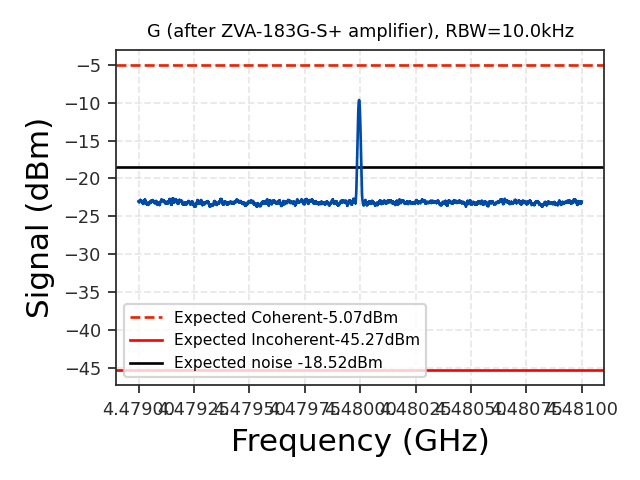

In [205]:
RBW = 10*kHz
FILENAME = "data/2021-08_photon-source/Ty_15_tracking-signal/Ty_15_tracking-signal_stage-G.txt"

noise = W_to_dBm(dBm_to_W(_noise) * RBW) 
signal_incoherent = W_to_dBm(dBm_to_W(_signal_incoherent) / INCOHRENT_SPREAD * RBW)

with open(FILENAME) as fin:
    data = np.loadtxt(fin, skiprows=1)
    
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.axhline(_signal_coherent, color=MY_COLOURS["DarkRed"], 
           linestyle="--",
           label=f"Expected Coherent{_signal_coherent:.2f}dBm")
ax.axhline(signal_incoherent, color="red", 
           label=f"Expected Incoherent{signal_incoherent:.2f}dBm")
ax.axhline(noise, color="black", label=f"Expected noise {noise:.2f}dBm")
ax.plot(data[:, 0]/1000, data[:, 1])
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal (dBm)")
ax.legend(fontsize=7)
ax.set_title(f"{LOCATION}, RBW={RBW/kHz}kHz", size=8)
plt.tight_layout()

plt.savefig(FILENAME.replace("txt", "pdf"))

## Signal at H
Next we perform downconversion of the signal. 
- Mix with generator (100kHz offset)
- 13 dBm refference signal

In [211]:
loss = 40
signal_coherent_8_dBm = signal_coherent_7_dBm - loss
signal_incoherent_8_dBm = signal_incoherent_7_dBm - loss
noise_8_dBm = noise_7_dBm - loss

In [212]:
LOCATION = "H (after mixer)"
_noise = noise_8_dBm
_signal_coherent = signal_coherent_8_dBm
_signal_incoherent = signal_incoherent_8_dBm

<IPython.core.display.Javascript object>


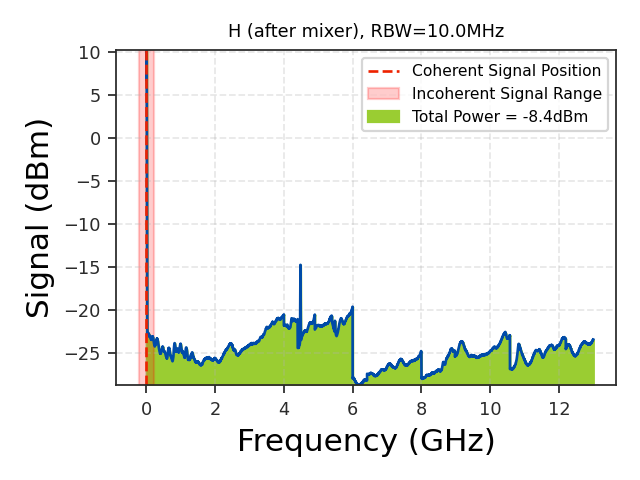

In [218]:
RBW = 10*MHz
FILENAME = "data/2021-08_photon-source/Ty_15_tracking-signal/Ty_15_tracking-signal_stage-H_wide.txt"

with open(FILENAME) as fin:
    data = np.loadtxt(fin, skiprows=1)
    data_x = data[:, 0] / 1000 # convert to GHz
    data_y = data[:, 1]
interpolation_dBm = InterpolatedUnivariateSpline(data_x, data_y, k=1)
interpolation_W = InterpolatedUnivariateSpline(data_x, dBm_to_W(data_y), k=1)
total_power = W_to_dBm(interpolation_W.integral(min(data_x), max(data_x)))
    
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(data_x, data_y)
ax.axvline(0./GHz, color=MY_COLOURS["DarkRed"], label=f"Coherent Signal Position",
           linestyle="--")
ax.axvspan((0.0001 - INCOHRENT_SPREAD/2)/GHz, 
           (0.0001 + INCOHRENT_SPREAD/2)/GHz, 
           color="red", alpha=0.2, label="Incoherent Signal Range")
ax.fill_between(data_x, min(data_y), interpolation_dBm(data_x), 
                color=MY_COLOURS["Green"],
               label=f"Total Power = {total_power:.1f}dBm")
ax.legend(fontsize=7)
ax.set_ylim([min(data_y), max(data_y)])
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal (dBm)");
ax.set_title(f"{LOCATION}, RBW={RBW/MHz}MHz", size=8)
plt.tight_layout()

plt.savefig(FILENAME.replace("txt", "pdf"))

<IPython.core.display.Javascript object>


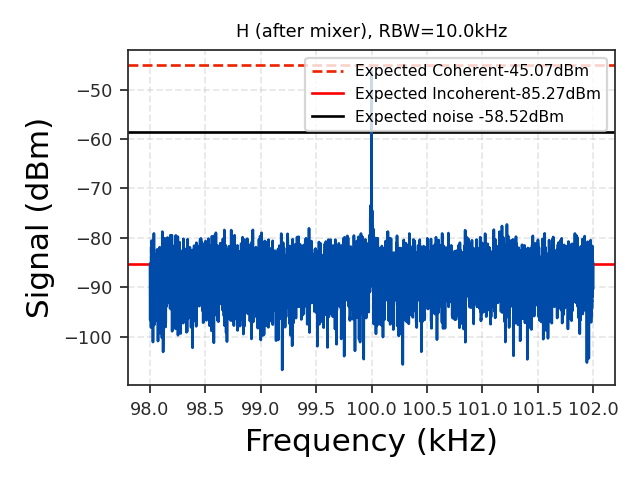

In [219]:
RBW = 10*kHz
FILENAME = "data/2021-08_photon-source/Ty_15_tracking-signal/Ty_15_tracking-signal_stage-H.txt"

noise = W_to_dBm(dBm_to_W(_noise) * RBW) 
signal_incoherent = W_to_dBm(dBm_to_W(_signal_incoherent) / INCOHRENT_SPREAD * RBW)

with open(FILENAME) as fin:
    data = np.loadtxt(fin, skiprows=1)
    
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.axhline(_signal_coherent, color=MY_COLOURS["DarkRed"], 
           linestyle="--",
           label=f"Expected Coherent{_signal_coherent:.2f}dBm")
ax.axhline(signal_incoherent, color="red", 
           label=f"Expected Incoherent{signal_incoherent:.2f}dBm")
ax.axhline(noise, color="black", label=f"Expected noise {noise:.2f}dBm")
ax.plot(data[:, 0]*1000, data[:, 1])
ax.set_xlabel("Frequency (kHz)")
ax.set_ylabel("Signal (dBm)")
ax.legend(fontsize=7)
ax.set_title(f"{LOCATION}, RBW={RBW/kHz}kHz", size=8)
plt.tight_layout()

plt.savefig(FILENAME.replace("txt", "pdf"))

In [221]:
# Amplifiers ZFL-500LN+
gain = 24
# Noise taken from calibration instead of temperature: jul-2021_-100dBm_spa_minicircuit
T = 295
noise_temp = 4*kb*T
noise_figure = 2.9

signal_coherent_9_dBm = signal_coherent_8_dBm + gain
signal_incoherent_9_dBm = signal_incoherent_8_dBm + gain
noise_9_dBm = W_to_dBm(
    dBm_to_W(noise_8_dBm + gain) + noise_temp * noise_figure
)

signal_coherent_9_dBm, signal_incoherent_9_dBm, noise_9_dBm

(-21.067651483454455, -15.04705157017483, -74.52371176758986)

## Signal at I

In [222]:
LOCATION = "I (after DC amplifier and filters)"
_noise = noise_9_dBm
_signal_coherent = signal_coherent_9_dBm
_signal_incoherent = signal_incoherent_9_dBm

<IPython.core.display.Javascript object>


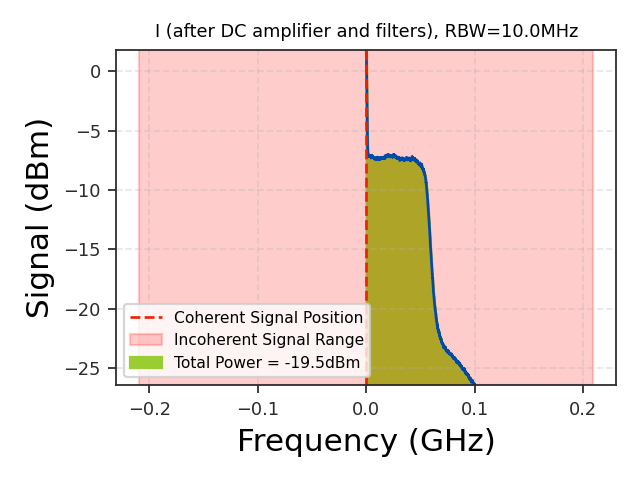

In [225]:
RBW = 10*MHz
FILENAME = "data/2021-08_photon-source/Ty_15_tracking-signal/Ty_15_tracking-signal_stage-I_wide.txt"

with open(FILENAME) as fin:
    data = np.loadtxt(fin, skiprows=1)
    data_x = data[:, 0] / 1000 # convert to GHz
    data_y = data[:, 1]
interpolation_dBm = InterpolatedUnivariateSpline(data_x, data_y, k=1)
interpolation_W = InterpolatedUnivariateSpline(data_x, dBm_to_W(data_y), k=1)
total_power = W_to_dBm(interpolation_W.integral(min(data_x), max(data_x)))
    
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(data_x, data_y)
ax.axvline(0.001/GHz, color=MY_COLOURS["DarkRed"], label=f"Coherent Signal Position",
           linestyle="--")
ax.axvspan((0.001 - INCOHRENT_SPREAD/2)/GHz, 
           (0.001 + INCOHRENT_SPREAD/2)/GHz, 
           color="red", alpha=0.2, label="Incoherent Signal Range")
ax.fill_between(data_x, min(data_y), interpolation_dBm(data_x), 
                color=MY_COLOURS["Green"],
               label=f"Total Power = {total_power:.1f}dBm")
ax.legend(fontsize=7)
ax.set_ylim([min(data_y), max(data_y)])
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal (dBm)");
ax.set_title(f"{LOCATION}, RBW={RBW/MHz}MHz", size=8)
plt.tight_layout()

plt.savefig(FILENAME.replace("txt", "pdf"))

<IPython.core.display.Javascript object>


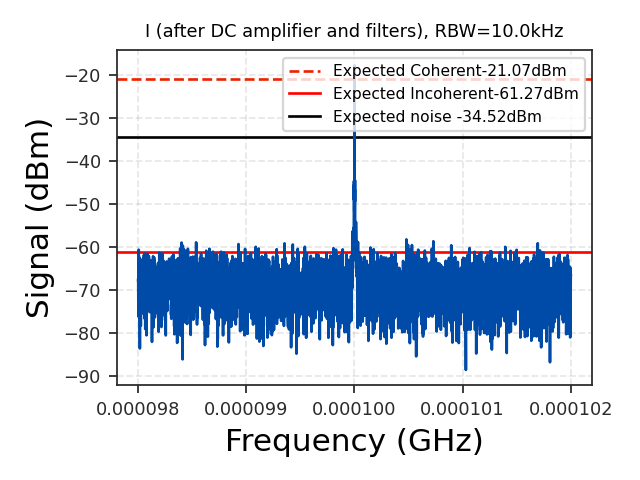

In [226]:
RBW = 10*kHz
FILENAME = "data/2021-08_photon-source/Ty_15_tracking-signal/Ty_15_tracking-signal_stage-I.txt"

noise = W_to_dBm(dBm_to_W(_noise) * RBW) 
signal_incoherent = W_to_dBm(dBm_to_W(_signal_incoherent) / INCOHRENT_SPREAD * RBW)

with open(FILENAME) as fin:
    data = np.loadtxt(fin, skiprows=1)
    
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.axhline(_signal_coherent, color=MY_COLOURS["DarkRed"], 
           linestyle="--",
           label=f"Expected Coherent{_signal_coherent:.2f}dBm")
ax.axhline(signal_incoherent, color="red", 
           label=f"Expected Incoherent{signal_incoherent:.2f}dBm")
ax.axhline(noise, color="black", label=f"Expected noise {noise:.2f}dBm")
ax.plot(data[:, 0]/1000, data[:, 1])
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal (dBm)")
ax.legend(fontsize=7)
ax.set_title(f"{LOCATION}, RBW={RBW/kHz}kHz", size=8)
plt.tight_layout()

plt.savefig(FILENAME.replace("txt", "pdf"))

In [229]:
# Finally at the digitiser, we are measuring the signal. The amount of codes the signal corresponds to is
voltage = dBm_to_V(signal_incoherent_9_dBm)
precision = 2.2 / (2**14)

voltage / precision

416.5284593431885